In [1]:
import numpy as np
import cv2
import sys
import glob
from matplotlib import pyplot as plt

In [2]:
def get_HOG_descriptors(img_gray, kps, win_size=(64, 64)):
    result = []
    for i, kp in enumerate(kps):
        # Read (x,y) coordinate from the current keypoint
        # https://docs.opencv.org/3.2.0/d2/d29/classcv_1_1KeyPoint.html
        x, y = kp.pt[0], kp.pt[1]

        # Create a win_size crop window for this keypoint
        left = int(x - (win_size[0]//2))
        right = int(x + (win_size[0]//2))
        if left < 0:
            left = 0
            right = left + win_size[0] + 1
        if right > img_gray.shape[1]-1:
            right = img_gray.shape[1]
            left = right - win_size[0] - 1
        top = int(y - (win_size[1]//2))
        bottom = int(y + (win_size[1]//2))
        if top < 0:
            top = 0
            bottom = top + win_size[1] + 1
        if bottom > img_gray.shape[0]-1:
            bottom = img_gray.shape[0]
            top = bottom - win_size[1] - 1

        # Crop the image with the window
        img_crop = img_gray[top:bottom, left:right]

        # Compute a HOG descriptor
        # Be careful, dimension of img_crop must match with winSize (as specified at hog initiation)
        desc = hog.compute(img_crop)

        # Add the descriptor to the resultant list
        result.append(desc)

    return np.asarray(result, np.float32)


In [3]:
# Initiate FAST detector
fast = cv2.FastFeatureDetector_create()

# Initiate HOG descriptor with default parameters
# size of the image sent to compute HOG
winSize = (16, 16)
# block size for block normalization
blockSize = tuple([i//2 for i in winSize])
blockStride = tuple([i//2 for i in blockSize])
# cell size (one cell for one 9-bin HOG)
cellSize = blockSize
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels)

# Initiate FLANN matching
# Since HOG descriptor is similar to SIFT/SURF descriptor, use the same matching technique
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)


In [4]:
# training data
dataset_path = "dataset/image/design1/*.jpg"
files = glob.glob(dataset_path) 

In [5]:
# create template
template_names = []
template_descs = []
template_bgrs = []
template_kpss = []
for item in files:
    name = item.split('/')[-1].split('.')[0]
    template_names.append(name)
    template_bgr = cv2.imread(item)
    template_bgr = cv2.resize(template_bgr,(256,256))
    template_gray = cv2.cvtColor(template_bgr, cv2.COLOR_BGR2GRAY)
    template_kps = fast.detect(template_gray, None)
    template_bgrs.append(template_bgr)
    template_kpss.append(template_kps)
    template_descs.append(get_HOG_descriptors(template_gray, template_kps, winSize))

In [17]:
# test data
test_path = "output/20210817_2134_select/*.jpg"
# test_path = "dataset/image/design1/*.jpg"
test_files = glob.glob(test_path) 

In [29]:
def detect_sign(dir):
    
    cam_bgr = cv2.imread(dir)
    cam_bgr = cv2.resize(cam_bgr,(128,128))
    print(cam_bgr.shape)
    cam_gray = cv2.cvtColor(cam_bgr, cv2.COLOR_BGR2GRAY)
    # Find FAST keypoints with non-maximum supression
    cam_kps = fast.detect(cam_gray, None)
    print(len(cam_kps))
    if len(cam_kps) > 1:
        # Find HOG descriptors
        cam_descs = get_HOG_descriptors(cam_gray, cam_kps, winSize)
        print(len(cam_descs))
        max_counter = 0
        max_matcher = None
        max_matchesMask = None
        max_template = None
        # Find two best matches
        for j in range(len(template_descs)):
            
            matches = flann.knnMatch(template_descs[j],   # query set of descriptors
                                    cam_descs,       # train set of descriptors
                                    k=2)             # only find two best matches for each query descriptor
            # print(len(template_descs[j]),'Match',len(matches))
            # Ratio test for eliminating poor matches
            matchesMask = [[0, 0] for i in range(len(matches))]
            counter = 0
            for i, mn in enumerate(matches):
                if (len(mn) == 2):                # prevent the case when only one match is found
                    m = mn[0]
                    n = mn[1]        # 'm' is the best match, 'n' is the second-best match
                    if m.distance < 0.7 * n.distance:
                        matchesMask[i] = [1, 0]
                        counter += 1
            
            if counter >= max_counter:
                max_counter = counter
                max_matcher = matches
                max_matchesMask = matchesMask
                max_template = j
        
        print('The number of good matches =', max_counter)
        # Draw matching result
        # cv2.drawMatchesKnn expects list of lists as matches.
        result = cv2.drawMatchesKnn(template_bgrs[max_template], template_kpss[max_template],
                                    cam_bgr, cam_kps,
                                    max_matcher,
                                    None,                          # output image
                                    # use random colors to draw the matching line
                                    matchColor=(-1, -1, -1),
                                    # use random colors to draw each keypoint
                                    singlePointColor=(-1, -1, -1),
                                    matchesMask=max_matchesMask,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        titles = [ 'cam_bgr', 'result']
        images = [ cam_bgr, result]
        fig = plt.figure(figsize=(15,8))
        fig.canvas.set_window_title('FAST+HOG: Feature Matching')
        for i in range(len(titles)):
            plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
            # cv2.imshow('FAST+HOG: Feature Matching', result)


(128, 128, 3)
12
12
The number of good matches = 24
(128, 128, 3)
0
(128, 128, 3)
2
2
The number of good matches = 118
(128, 128, 3)
0
(128, 128, 3)
11
11


/var/folders/81/801rlldj66b9mqn09r7s37jr0000gn/T/ipykernel_30577/3265581737.py:58: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('FAST+HOG: Feature Matching')


The number of good matches = 31
(128, 128, 3)
0
(128, 128, 3)
17
17
The number of good matches = 17
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
41
41
The number of good matches = 52
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
0
(128, 128, 3)
1
(128, 128, 3)
19
19
The number of good matches = 6
(128, 128, 3)
6
6
The number of good matches = 64
(128, 128, 3)
0


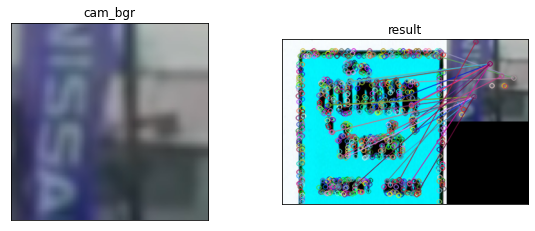

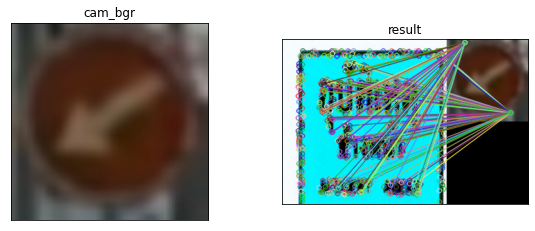

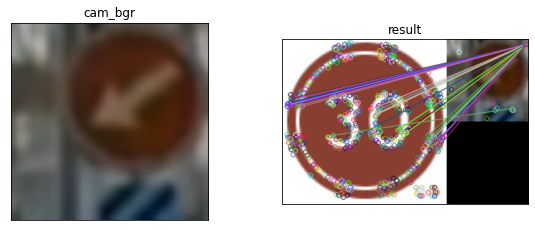

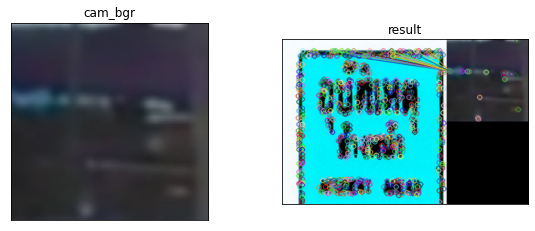

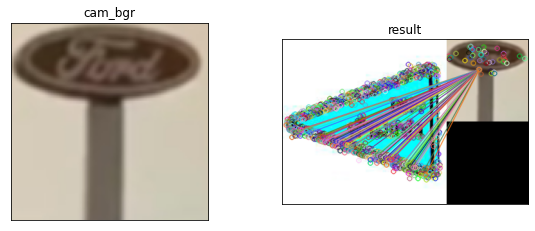

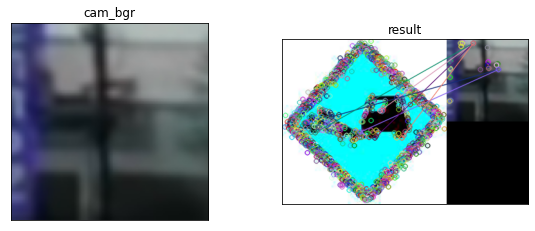

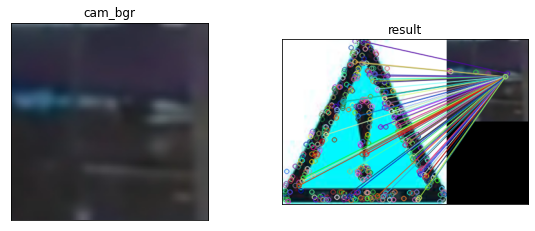

In [30]:
for item in test_files:
    # print(item)
    # try:
    detect_sign(item)
    
    # except:
    #     print(item)